# World Heritage Outlook analysis 2 - 2017

## Update runs
- 170724 Run
- 170817 Run 
- 170913 Run
- 170929 Run
- 171011 Run
- 171027 Run

## About

The 2017 cycle of assessments will not be ready until later September/October. This notebook is an attempt to:

1. Experiment the methodology that allows rapid analysis to be repeated with little efforts. The goal is to complete the analysis within short time, when the final data have become available
2. Experiment open and reproducible analysis that anyone interested could critique, repeat or improve the methodolgy if they so wish
3. Test ideas and scrutise the result, to uncover inconsistency and enable future iterations of outlook assessment to be more systematic and consistent

### The analysis so far
- load CSV data (pre-processed data dumps from PostgreSQL/MS Access) into the notebook
- utility functions to find relevant rows in the data, based on `wdpaid` and `assessment_cycle`
- generic summary statistics (using `pandas.DataFrame.pivot_table`), for the `overall` table, notably including the `outlook` ratings. This is implemented so that any dataframe with filtered rows could be done easily, i.e., allowing subsetting by regions, countries, any attribute criteria
- generic field-by-field change detction for the `overall` table. This is useful to identify the lowest level change (i.e. field level change for each site) but also provides a mechanism for quality control as odd changes that should not happen could be easily identified
- generic pivot table counting for any data. I tested the functionality using `potential_threat`, in which different groups of threat categories are needed
- viz: outlook, and its comparison
- viz: heatmap for threats, the charts are interactive, allowing users to interrogate each cell (powered by Plot.ly)
- finding associations between values, pm and threats to the final outlook rating
- finding inconsistencies between individual threat listing and severity to the final threat rating 
- find sites and analyse based on internal filters, such as specific threats or management
- regional filters are now in place for the overall table
    
### Ideas
- attribute filters: regions, marine, country, WH criteria, danger status. This could be easily implemented as the only change would be the input. As long as the analysis is designed in such a way that allow such input to be changed at a later stage.

## Data preparation and exploration

Load relevant analytical and graphing libraries

In [1]:
import os, sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# %matplotlib inline

import plotly library for plotting

In [3]:
#install openpyxl, if needed
!pip install openpyxl

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import plotly
plotly.tools.set_credentials_file(username='yichuans', api_key='DjWuYpvtG8nFh8A9U8Jb')

# ensure offline viewing of plotly graphs
# plotly.offline.init_notebook_mode(connected=True)

import plotly.plotly as py
import plotly.figure_factory as ff

from plotly.graph_objs import Bar

Checking folder structure - for the analysis to correctly continue, you must have `WH_attributes_2017.csv`, `overall.csv`, `potential_threat.csv`, `current_threat.csv`, `protection_manament_threat.csv`, `who_value_current_threat.csv` and `who_value_potential_threat.csv`. These tables are obtained using the methodology previoulsy employed during the 2014 assessment. For detailed steps please consult Yichuan or Matea. 

In [5]:
!ls

171027.zip
WH_attributes_2017.csv
WH_region.csv
WH_region_v2.csv
analysis.ipynb
current_threat.csv
old
old170817
old170929
old171011
old171027
output_changed_stats.xlsx
output_changed_stats_by_site.xlsx
output_cycle2014_summary.xlsx
output_cycle2017_summary.xlsx
output_region_cycle2014_summary_Africa.xlsx
output_region_cycle2014_summary_Arab_States.xlsx
output_region_cycle2014_summary_Asia_and_the_Pacific.xlsx
output_region_cycle2014_summary_Europe_and_North_America.xlsx
output_region_cycle2014_summary_Latin_America_and_the_Caribbean.xlsx
output_region_cycle2017_summary_Africa.xlsx
output_region_cycle2017_summary_Arab_States.xlsx
output_region_cycle2017_summary_Asia_and_the_Pacific.xlsx
output_region_cycle2017_summary_Europe_and_North_America.xlsx
output_region_cycle2017_summary_Latin_America_and_the_Caribbean.xlsx
overall.csv
potential_threat.csv
protection_management.csv
who_value.csv
who_value_current_threat.csv
who_value_potential_threat.csv


Loading data into dataframes

In [6]:
overall = pd.read_csv('overall.csv', encoding='latin1')
current_threat = pd.read_csv('current_threat.csv', encoding='latin1')
potential_threat = pd.read_csv('potential_threat.csv', encoding='latin1')
protection_management = pd.read_csv('protection_management.csv', encoding='latin1')
value_current_threat = pd.read_csv('who_value_current_threat.csv', encoding='latin1')
value_potential_threat = pd.read_csv('who_value_potential_threat.csv', encoding='latin1')
wh_attr = pd.read_csv('WH_attributes_2017.csv')
wh_region = pd.read_csv('WH_region.csv')

Remove col not needed

In [7]:
for tab in [overall, current_threat, potential_threat, protection_management, value_current_threat, value_potential_threat]:
    if 'screenname' in tab.columns:
        tab.drop(columns=['screenname'], inplace=True)

In [8]:
# check again
for tab in [overall, current_threat, potential_threat, protection_management, value_current_threat, value_potential_threat]:
    if 'screenname' in tab.columns:
        print('Not dropped correctly')

For consistency checks, we need to ensure the number of records are consistent with our knowledge of the assessments. The `overall.index.size` indicates the number of rows (2014 + 2017) and `overall.wdpa_id.unique()` the unique number of sites for 2014 and 2017. When the 2017 assessments are uploaded to the database in full, we expect it to be **241**

In [9]:
overall.index.size, overall.wdpa_id.nunique()

(469, 241)

The below checks on whether `pm_rating` has been filled for all assessments, if any values are labelled `NaN`, we need to validate if assessment for each topic is complete as it should.

In [10]:
protection_management[pd.isnull(protection_management.pm_rating)]

wdpa_id       status       stage  \
932      903062    Completed      Review   
2142       2012    Completed      Review   
2168      26689    Completed      Review   
2190      67730    Completed      Review   
2194       5001    Completed      Review   
2237       2575    Completed      Review   
2246     145585    Completed      Review   
2262      10907    Completed      Review   
2285      17761    Completed      Review   
2300      93295    Completed      Review   
2317      17758    Completed    Approved   
2333  555547988    Completed    Approved   
2349       2017    Completed    Approved   
2365     145586    Completed    Approved   
2381       2578    Completed    Approved   
3498      61609    Completed  Assessment   
3512  555556048    Completed  Assessment   
3530  555577555    Completed  Assessment   
3539     903138    Completed  Assessment   
3561      93767    Completed  Assessment   
3573     902479    Completed  Assessment   
3593     903132    Completed  Assessment   
3614     903135    Completed  Assessment   
3629      18862    Completed  Assessment   
3643       9613    Completed  Assessment   
3660      12206    Completed  Assessment   
3682     145580    Completed  Assessment   
3699     903134    Completed  Assessment   
3728      20399    Completed  Assessment   
3729      20399    Completed  Assessment   
...         ...          ...         ...   
6514     220296    Completed  Assessment   
6539       2573  In Progress  Assessment   
6540       2573  In Progress  Assessment   
6552  555512003    Completed  Assessment   
6569  555622045    Completed      Review   
6575       4999    Completed      Review   
6597  555547992  In Progress  Assessment   
6598  555547992  In Progress  Assessment   
6633     902487    Completed      Review   
6645       2580    Completed  Assessment   
6661  555622043    Completed      Review   
6678      17759    Completed      Review   
6688      16792    Completed  Assessment   
6707      10904    Completed      Review   
6724  555547989    Completed  Assessment   
6753     220295    Completed  Assessment   
6776     900632    Completed      Review   
6782     902335    Completed  Assessment   
6805      12202    Completed  Assessment   
6844      20171    Completed  Assessment   
6876     478641    Completed  Assessment   
6900      10902    Completed      Review   
6906       2572    Completed      Review   
6929      61604    Completed      Review   
6950     900010  In Progress  Assessment   
6951     900010  In Progress  Assessment   
6967     903133    Completed  Assessment   
6995     902368    Completed  Assessment   
7000     900878    Completed  Assessment   
7023      12207    Completed      Review   

                                                name_en  \
932                       Rainforests of the Atsinanana   
2142                           Everglades National Park   
2168                      Canadian Rocky Mountain Parks   
2190                                      Fraser Island   
2194                             Lord Howe Island Group   
2237                            Serengeti National Park   
2246           Mount Kenya National Park/Natural Forest   
2262  Mana Pools National Park, Sapi and Chewore Saf...   
2285                          Kilimanjaro National Park   
2300          Waterton-Glacier International Peace Park   
2317                                 Dja Faunal Reserve   
2333                                 Sangha Trinational   
2349                              Virunga National Park   
2365                        Lake Turkana National Parks   
2381                     Djoudj National Bird Sanctuary   
3498                  Bwindi Impenetrable National Park   
3512                                     Namib Sand Sea   
3530                                     Okavango Delta   
3539                                Socotra Archipelago   
3561                     Gough and Inaccessible Islands   
3573  Coiba National Park and its Specia

## Overall conservation outlook

Filters for 2014 and 2017 cycles of assessment so that different versions can be specified easily. Note this is only a *convenient* method for the overall table alone.

In [11]:
CYCLE_2017_OVERALL = overall.assessment_cycle == 2017
CYCLE_2014_OVERALL = overall.assessment_cycle == 2014

The number of unique records for 2014 and 2017 cycles

In [12]:
overall[CYCLE_2014_OVERALL].wdpa_id.nunique(), overall[CYCLE_2017_OVERALL].wdpa_id.nunique()

(229, 240)

Quality checks on the data: what are the sites that are in 2014 but not in 2017 and vice versa? Or what is the number of sites that have two assessments?

In [13]:
wdpaid_shared_between_cycles = overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id.values)
print('Total number of shared sites between two cycles: {}'.format(wdpaid_shared_between_cycles.sum()))

Total number of shared sites between two cycles: 228


#### Regions
Regional filters

In [14]:
wh_region.unesco_region.unique()

array(['Africa', 'Arab States', 'Asia and the Pacific',
       'Europe and North America', 'Latin America and the Caribbean'],
      dtype=object)

`region_dict` is a dictionary of region_name: list of wdpaid in that region

In [15]:
region_dict = {region_name: wh_region[wh_region.unesco_region==region_name].wdpaid \
              for region_name in wh_region.unesco_region.unique()}

### Overall outlook statistics

Overall outlook for 2014

In [16]:
overall[CYCLE_2014_OVERALL].pivot_table(values='wdpa_id', columns='outlook', aggfunc=np.count_nonzero)

outlook  Critical  Good  Good with some concerns  Significant Concern
wdpa_id        19    47                       97                   66

A more generic version of number statistics are needed to facilitate pivot tables

In [17]:
## create a more generic version of get number statistics
def summary_statistics(df, columns, aggfunc=np.count_nonzero):
    result = df.pivot_table(values='wdpa_id', columns=columns, aggfunc=aggfunc)
    result.index = [' '] # remove wdpa_id as index value
    return result

For example, the previous pivot table analysis could be re-calculated as the following, i.e. overall outlook for 2014

In [18]:
summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook')

outlook  Critical  Good  Good with some concerns  Significant Concern
               19    47                       97                   66

With the `summary_statistics` function, one further automation could be achieved by looping with the different column names.

The below loops through all columns name and count the number of sites by rating, iteratively, for 2014 assessment. I also made a copy of Excel table to facilitate intepretation for those prefer Excel tables. This allows also other visualisations to be created outside the notebook environment

#### Overall result for 2014

The below shows the count by category for outlook, threat, protection and management, and value 

In [19]:
# write to excel
writer = pd.ExcelWriter('output_cycle2014_summary.xlsx')

cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
for col in cols:
    col_result = summary_statistics(overall[CYCLE_2014_OVERALL], col)
    col_result.to_excel(writer, col)
    print col_result
    
writer.save()

status  Completed  In Progress
              228            1
stage  Approved  Assessment  Published  Translated
              1           1        224           3
outlook  Critical  Good  Good with some concerns  Significant Concern
               19    47                       97                   66
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         90          88                33               18
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         89          91                30               19
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                              26           84          71                24   

potential_threat  Very Low Threat  
                               15  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                 103                23               29            74
wh_value  Critical  Good 

#### Overall result for 2014 by region
Similar to the above but by region

In [20]:
for region in region_dict:
    print '\n----' + '-'*len(region) + '----'
    print '    ' + region + '    '
    print '----' + '-'*len(region) + '----\n'
    writer = pd.ExcelWriter('output_region_cycle2014_summary_{}.xlsx'.format(region.replace(' ', '_')))

    cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
    for col in cols:
        df = overall[CYCLE_2014_OVERALL & overall.wdpa_id.isin(region_dict[region])]
        col_result = summary_statistics(df, col)
        col_result.to_excel(writer, col)
        print col_result
    writer.save()


--------------------------------
    Europe and North America    
--------------------------------

status  Completed
               71
stage  Published
              71
outlook  Critical  Good  Good with some concerns  Significant Concern
                1    23                       32                   15
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         22          31                 5               13
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         25          27                 4               15
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                               8           23          23                 5   

potential_threat  Very Low Threat  
                               11  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                  36                12                5            18
wh_value  Critical

#### Overall result for 2017

In [21]:
# also write to excel
writer = pd.ExcelWriter('output_cycle2017_summary.xlsx')

cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
for col in cols:
    col_result = summary_statistics(overall[CYCLE_2017_OVERALL], col)
    col_result.to_excel(writer, col)
    print col_result
    
writer.save()

status  Completed  In Progress
              225           15
stage  Approved  Assessment  Review
              5         203      32
outlook  Critical  Good  Good with some concerns  Significant Concern
               16    47                      103                   74
overall_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                             1          101          90                34   

overall_threat  Very Low Threat  
                             14  
current_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                             2          105          85                31   

current_threat  Very Low Threat  
                             17  
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                              25           92          81                23   

potential_threat  Very Low Threat  
                               14  
prot_mgmt  Effective  Highly Effective  Serious C

By adding further filters, such as regions/countries/(other attributes), in the form of list of wdpaids, it can calculate statistics reusing the `summary_statistics` function. TBD: apply wdpaid filter, perhaps `isin`

#### Overall result for 2017 by region
Similar to the above but by region

In [22]:
for region in region_dict:
    print '\n----' + '-'*len(region) + '----'
    print '    ' + region + '    '
    print '----' + '-'*len(region) + '----\n'
    writer = pd.ExcelWriter('output_region_cycle2017_summary_{}.xlsx'.format(region.replace(' ', '_')))

    cols = [u'status', u'stage', u'outlook', u'overall_threat', u'current_threat', u'potential_threat', u'prot_mgmt', u'wh_value', u'wh_trend', u'biodiv_value', u'biodiv_trend', u'language']
    for col in cols:
        df = overall[CYCLE_2017_OVERALL & overall.wdpa_id.isin(region_dict[region])]
        col_result = summary_statistics(df, col)
        col_result.to_excel(writer, col)
        print col_result
    writer.save()


--------------------------------
    Europe and North America    
--------------------------------

status  Completed  In Progress
               68            4
stage  Assessment  Review
               63       9
outlook  Critical  Good  Good with some concerns  Significant Concern
                1    22                       29                   20
overall_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         27          29                 6               10
current_threat  High Threat  Low Threat  Very High Threat  Very Low Threat
                         33          24                 3               12
potential_threat  Data Deficient  High Threat  Low Threat  Very High Threat  \
                               9           21          26                 5   

potential_threat  Very Low Threat  
                               11  
prot_mgmt  Effective  Highly Effective  Serious Concern  Some Concern
                  29                12      

### Overall outlook visualisation
Investigate visualisation options, for overall outlook. 

In [23]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [24]:
plt.style.use('ggplot')

The default style with `ggplot`

In [25]:
def plot_outlook(df):
    # use WHO colour scheme
    red, orange, green, deep_green, grey =('#E22626','#F69220', '#ACCD73', '#49AA4A', '#A0A0A0')
    fig, axes = plt.subplots(1, figsize=(20, 2))
    
    my_colors = [deep_green, green, orange, red]
    my_labels = ['Good', 'Good with some concerns', 'Significant Concern', 'Critical']
    data = df[my_labels]

    c = data.plot.barh(ax=axes, stacked=True, color=my_colors)
    axes.set_xlim([0, data.values.sum()])
    axes.legend_.remove()
    
    # ensure all 1-d array to zip, thus flatten
    for value, value_cum, label in zip(data.values.flatten(), data.values.cumsum(), my_labels):
        axes.annotate(label + ' ({})'.format(value), (value_cum - value/2.0, 0),
                      horizontalalignment='center', verticalalignment='center')
    
    return fig

In [26]:
## a genric plot function, requiring the scheme to be sorted before hand
def plot_summary_statistics(df):
    # use WHO colour scheme
    red, orange, green, deep_green, grey =('#E22626','#F69220', '#ACCD73', '#49AA4A', '#A0A0A0')
    fig, axes = plt.subplots(1, figsize=(20, 2))
    
    my_colors = [deep_green, green, orange, red, grey]
    my_labels = df.columns
    data = df

    c = data.plot.barh(ax=axes, stacked=True, color=my_colors)
    axes.set_xlim([0, data.values.sum()])
    axes.legend_.remove()
    
    # ensure all 1-d array to zip, thus flatten
    for value, value_cum, label in zip(data.values.flatten(), data.values.cumsum(), my_labels):
        axes.annotate(label + ' ({})'.format(value), (value_cum - value/2.0, 0),
                      horizontalalignment='center', verticalalignment='center')
    
    return fig

**Overall outlook 2014**

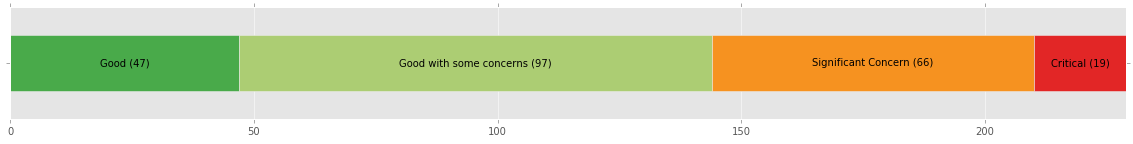

In [27]:
plot_outlook(summary_statistics(overall[CYCLE_2014_OVERALL], 'outlook'))

**Overall outlook 2017**

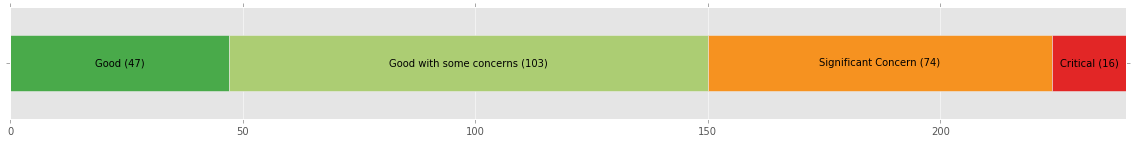

In [28]:
plot_outlook(summary_statistics(overall[CYCLE_2017_OVERALL], 'outlook'))

Testing generic statistics ploting function, noting the need to re-order columns

**Potential threat 2014**

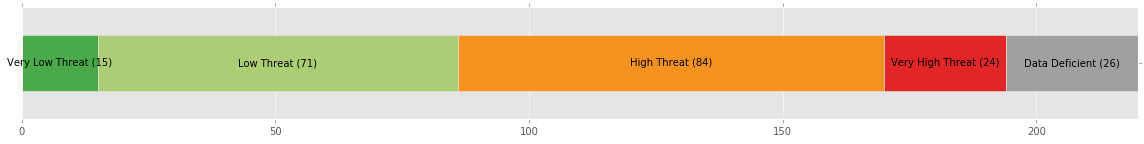

In [29]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2014_OVERALL], 'potential_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**Potential threat 2017**

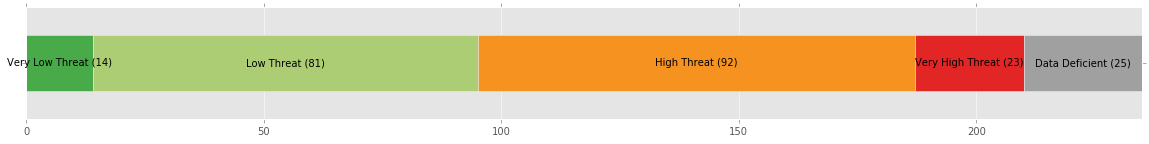

In [30]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2017_OVERALL], 'potential_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**Current threat 2014**

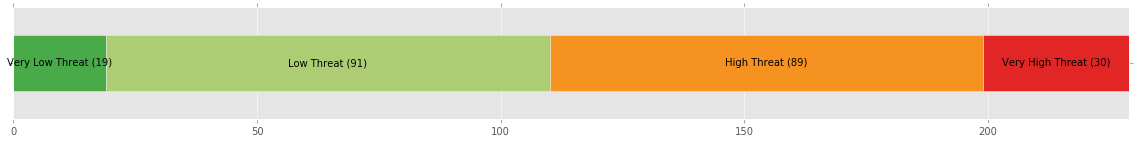

In [31]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2014_OVERALL], 'current_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat']])

**Current threat 2017**

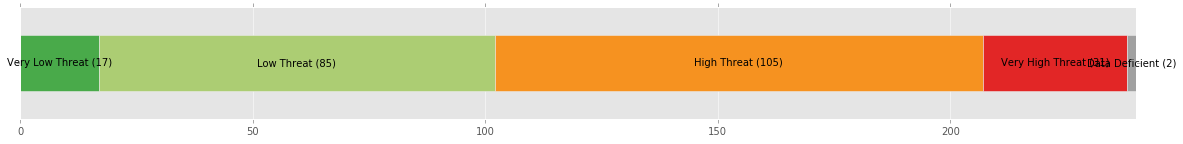

In [32]:
plot_summary_statistics(summary_statistics(overall[CYCLE_2017_OVERALL], 'current_threat')[['Very Low Threat','Low Threat','High Threat','Very High Threat', 'Data Deficient']])

**Protection and management 2014**

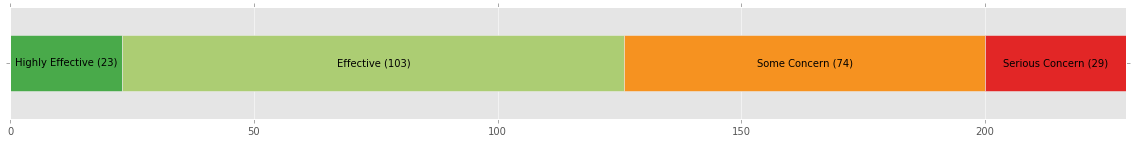

In [33]:
plot_summary_statistics(
    summary_statistics(overall[CYCLE_2014_OVERALL], 'prot_mgmt')[[ 'Highly Effective','Effective', 'Some Concern','Serious Concern']])

**Protection and management 2017**

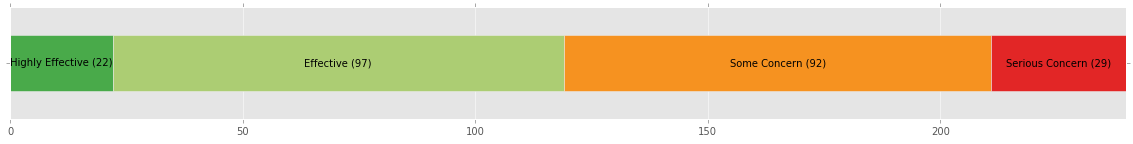

In [34]:
plot_summary_statistics(
    summary_statistics(overall[CYCLE_2017_OVERALL], 'prot_mgmt')[['Highly Effective','Effective', 'Some Concern','Serious Concern']])

### Detect change from 2014 and 2017

It is desirable to know what change may have occurred in each site (if any). The goal is to identify at the lowest level, i.e., for each column, for example, what has 'current threat' changed for Galapogas from 2014 to 2017

In [35]:
common_wdpaids = overall[CYCLE_2014_OVERALL].wdpa_id[overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id)]

In [36]:
def detect_change_col(wdpaid, df, col):
    """"one row per cycle, i.e. one to one relationship"""
    # brutal force not efficient, first row
    value_2017 = df[(df.assessment_cycle==2017) & (df.wdpa_id==wdpaid)][col].iloc[0]
    value_2014 = df[(df.assessment_cycle==2014) & (df.wdpa_id==wdpaid)][col].iloc[0]
    
    if value_2017 == value_2014:
        return None
    
    # if both variables are of type float and nan, don't do anything
    elif isinstance(value_2017, float) and isinstance(value_2014, float):
        if math.isnan(value_2017) and math.isnan(value_2014):
            return None
        
    # detected change, record
    else:
        return ' -> '.join(map(str, [value_2014, value_2017]))

def detect_change_df(df):
    output = list()
    
    # go through all fields and remove unnecesary fields
    excluded_cols = ['wdpa_id', 'screenname', 'status', 'stage', 'assessment_cycle']
    cols = df.columns.tolist()

    for excluded_col in excluded_cols:
        if excluded_col in cols:
            cols.remove(excluded_col)
    
    # for each site do detection check
    for wdpaid in common_wdpaids:
        for col in cols:
            result = detect_change_col(wdpaid, df, col)
            # if detected
            if result:
                output.append([wdpaid, col, result])
    
    # append en_name 
    output_df = pd.DataFrame(data=output, columns=['wdpaid', 'column', 'value'])
    output_full = pd.merge(output_df, wh_attr, how='inner', on='wdpaid')[['wdpaid', 'en_name', 'column', 'value']]
    
    return output_full

In [37]:
changed_stats = detect_change_df(overall)

Example of the result of change per column

In [38]:
changed_stats.head(20)

wdpaid                                   en_name            column  \
0     2010              Ngorongoro Conservation Area      biodiv_value   
1     2010              Ngorongoro Conservation Area      biodiv_trend   
2    17761                 Kilimanjaro National Park      biodiv_value   
3    17761                 Kilimanjaro National Park      biodiv_trend   
4     2580                Niokolo-Koba National Park  potential_threat   
5     2580                Niokolo-Koba National Park      biodiv_value   
6   902487              Wadi Al-Hitan (Whale Valley)           outlook   
7    67727           Aïr and Ténéré Natural Reserves  potential_threat   
8    67727           Aïr and Ténéré Natural Reserves         prot_mgmt   
9    67727           Aïr and Ténéré Natural Reserves          language   
10   61608          Rwenzori Mountains National Park    overall_threat   
11   61608          Rwenzori Mountains National Park    current_threat   
12   61608          Rwenzori Mountains National Park         prot_mgmt   
13    4322                     Ichkeul National Park           outlook   
14    4322                     Ichkeul National Park          wh_value   
15    4322                     Ichkeul National Park          language   
16   26653  Tsingy de Bemaraha Strict Nature Reserve           outlook   
17   26653  Tsingy de Bemaraha Strict Nature Reserve    overall_threat   
18   26653  Tsingy de Bemaraha Strict Nature Reserve    current_threat   
19    4328                Kahuzi-Biega National Park          wh_trend   

                                             value  
0                               nan -> Low Concern  
1                            nan -> Data Deficient  
2                    Data Deficient -> Low Concern  
3                  Data Deficient -> Deteriorating  
4                  High Threat -> Very High Threat  
5                       Critical -> Data Deficient  
6                  Good -> Good with some concerns  
7                    Data Deficient -> High Threat  
8                  Serious Concern -> Some Concern  
9                                           1 -> 2  
10                       Low Threat -> High Threat  
11                       Low Threat -> High Threat  
12                       Effective -> Some Concern  
13  Significant Concern -> Good with some concerns  
14                     High Concern -> Low Concern  
15                                          2 -> 1  
16                 Good -> Good with some concerns  
17                       Low Threat -> High Threat  
18                       Low Threat -> High Threat  
19                 Data Deficient -> Deteriorating

The above table exported to an excel table `output_changed_stats.xlsx`

In [39]:
# export to excel
writer = pd.ExcelWriter('output_changed_stats.xlsx')
changed_stats.to_excel(writer, encoding='utf-8')
writer.save()

`pd.pivot` can be used to identify site specific change for all fields. Note the `columns` argument that for each value in the column would be made a column in the resulting pivot table

In [40]:
changed_stats_by_site = changed_stats.pivot( 'en_name', columns='column', values='value')

#### Site level change in overall from 2014 - 2017

In [41]:
changed_stats_by_site

column                                                                 biodiv_trend  \
en_name                                                                               
Alejandro de Humboldt National Park                           Data Deficient -> nan   
Area de Conservación Guanacaste                                                None   
Atlantic Forest Southeast Reserves                                             None   
Aïr and Ténéré Natural Reserves                                                None   
Belize Barrier Reef Reserve System                                             None   
Białowieża Forest                                                              None   
Brazilian Atlantic Islands: Fernando de Noronha...                             None   
Bwindi Impenetrable National Park                                     nan -> Stable   
Canadian Rocky Mountain Parks                               Stable -> Deteriorating   
Canaima National Park                                                          None   
Cape Floral Region Protected Areas                                             None   
Carlsbad Caverns National Park                          Data Deficient -> Improving   
Caves of Aggtelek Karst and Slovak Karst                                       None   
Central Amazon Conservation Complex                                            None   
Central Sikhote-Alin                                                           None   
Central Suriname Nature Reserve                                                None   
Cerrado Protected Areas: Chapada dos Veadeiros ...                             None   
Cocos Island National Park                                    Data Deficient -> nan   
Coiba National Park and its Special Zone of Mar...                             None   
Comoé National Park                                                            None   
Danube Delta                                                          nan -> Stable   
Darien National Park                                Deteriorating -> Data Deficient   
Desembarco del Granma National Park                        Data Deficient -> Stable   
Dinosaur Provincial Park                                                       None   
Dja Faunal Reserve                                                             None   
Djoudj National Bird Sanctuary                                     nan -> Improving   
Dong Phayayen-Khao Yai Forest Complex                                          None   
Dorset and East Devon Coast                                                    None   
East Rennell                                                                   None   
El Pinacate and Gran Desierto de Altar Biospher...                             None   
...                                                                             ...   
Stevns Klint                                                                   None   
Sundarbans National Park                                                       None   
Surtsey                                                            nan -> Improving   
Swiss Alps Jungfrau-Aletsch                                Data Deficient -> Stable   
Tasmanian Wilderness                                               nan -> Improving   
Tassili n'Ajjer                                                                None   
Taï National Park                                                              None   
The Dolomites                                              Data Deficient -> Stable   
Three Parallel Rivers of Yunnan Protected Areas               nan -> Data Deficient   
Thungyai - Huai Kha Khaeng Wildlife Sanctuaries                                None   
Tikal National Park                                 Deteriorating -> Data Deficient   
Tongariro National Park                                               nan -> Stable   
Trang An Landscape Complex                                                     None  

In [42]:
# export to excel
writer = pd.ExcelWriter('output_changed_stats_by_site.xlsx')
changed_stats_by_site.to_excel(writer, encoding='utf-8')
writer.save()

## Detailed results for threats, protection and management

Check the unique categories for both threats, protection and management

In [43]:
protection_management.pm_rating.unique()

array([u'Effective', u'Highly Effective', u'Data Deficient',
       u'Some Concern', u'Serious Concern', nan], dtype=object)

In [44]:
current_threat.rating.unique()

array([u'Low Threat', u'Very Low Threat', u'High Threat',
       u'Data Deficient', u'Very High Threat'], dtype=object)

Specify settings in list and dictionaries for convenience

In [45]:
# threat ratings for ordering df
threat_ratings = ['Data Deficient', u'Very Low Threat', u'Low Threat', 'High Threat', u'Very High Threat']
pm_ratings = ['Data Deficient', 'Highly Effective','Effective', 'Some Concern', 'Serious Concern']

# use a dict to unpack arguments, easier to see
# fill_value=0 removes NaN values
threat_pivot_settings = dict(values='wdpa_id', index=['threat_category', 'threat_sub_category'],
                             columns='rating', aggfunc=np.count_nonzero, fill_value=0)
pm_pivot_settings = dict(values='wdpa_id', index=['topic'],
                             columns='pm_rating', aggfunc=np.count_nonzero, fill_value=0)

Result for potential threat change. `pt_2014` represents 2014 result, `pt_2017` 2017 result, `pt_change` the change between 2014 and 2017

In [46]:
# potential threat
pt_2014 = potential_threat[potential_threat.assessment_cycle==2014].pivot_table(**threat_pivot_settings)
pt_2017 = potential_threat[potential_threat.assessment_cycle==2017].pivot_table(**threat_pivot_settings)
pt_change = pd.merge(pt_2014, pt_2017, how='inner', left_index=True, right_index=True)

for rating in threat_ratings:
    # 2017 minus 2014
    pt_change[rating + '_change'] = pt_change[rating + '_y'] - pt_change[rating + '_x']
    
    # drop x, y fields, in place
    pt_change.drop(rating + '_x', axis=1, inplace=True)
    pt_change.drop(rating + '_y', axis=1, inplace=True)

Similarly for current threats

In [47]:
# current threat
ct_2014 = current_threat[current_threat.assessment_cycle==2014].pivot_table(**threat_pivot_settings)
ct_2017 = current_threat[current_threat.assessment_cycle==2017].pivot_table(**threat_pivot_settings)
ct_change = pd.merge(ct_2014, ct_2017, how='inner', left_index=True, right_index=True)

for rating in threat_ratings:
    # 2017 minus 2014
    ct_change[rating + '_change'] = ct_change[rating + '_y'] - ct_change[rating + '_x']
    
    # drop x, y fields, in place
    ct_change.drop(rating + '_x', axis=1, inplace=True)
    ct_change.drop(rating + '_y', axis=1, inplace=True)

For protection and management

In [48]:
# protection and management
pm_2014 = protection_management[protection_management.assessment_cycle==2014].pivot_table(**pm_pivot_settings)
pm_2017 = protection_management[protection_management.assessment_cycle==2017].pivot_table(**pm_pivot_settings)
pm_change = pd.merge(pm_2014, pm_2017, how='inner', left_index=True, right_index=True)

for rating in pm_ratings:
    # 2017 minus 2014
    pm_change[rating + '_change'] = pm_change[rating + '_y'] - pm_change[rating + '_x']
    
    # drop x, y fields, in place
    pm_change.drop(rating + '_x', axis=1, inplace=True)
    pm_change.drop(rating + '_y', axis=1, inplace=True)

Generic heat map for visualisation. It presents a better method of spotting hotspot and coldspot

In [49]:
def heat_map(df, title, colorscale=[[0, '#fffff2'], [0.5, 'fd8d3c'], [1, '#bd0026']]):
    import plotly.graph_objs as go

    # index
    if type(df.index) == pd.core.indexes.multi.MultiIndex:
        y = [': '.join(each) for each in df.index.tolist()]
    elif type(df.index) == pd.core.indexes.base.Index:
        y = df.index.tolist()
    else:
        raise Exception('index type error {}'.format(type(df.index)))
    
    data = [go.Heatmap(z=df.values.tolist(), x=df.columns.tolist(),
                       y=y,
                       colorscale=colorscale)]

    layout = go.Layout(
    #     width=600,
        height=800,
        title=title,
        yaxis=dict(
            tickfont=dict(
                size=8
            )
        ))

    fig = go.Figure(data=data, layout=layout)
    # plot offline
#     plotly.offline.plot(fig)
    return py.iplot(fig, filename=title+'_heatmap')

### Potential threat

#### 2014

In [50]:
# the columns are for ordering only
pt_2014[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            0   
                                                 Forestry/ Wood production                                        0   
                                                 Livestock Farming / Grazing                                      0   
                                                 Marine/ Freshwater Aquaculture                                   1   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           1   
                                                 Hunting (commercial/subsistence)                                 0   
                                                 Logging/ Wood Harvesting                                         1   
                                                 Poaching                                                         0   
Climate Change and Severe Weather                Desertification                                                  0   
                                                 Droughts                                                        12   
                                                 Habitat Shifting/ Alteration                                    14   
                                                 Ocean acidification                                              1   
                                                 Storms/Flooding                                                  8   
                                                 Temperature extremes                                            19   
Energy Production and Mining                     Mining/ Quarrying                                                6   
                                                 Oil/ Gas exploration/development                                 6   
                                                 Renewable Energy                                                 3   
Geological Events                                Avalanches/ Landslides                                           2   
                                                 Earthquakes/ Tsunamis                                            3   
                                                 Erosion and Siltation/ Deposition                                0   
                                                 Volcanoes                                                        1   
Human Intrusions and Disturbance                 Other Activities                                                 1   
                                                 Tourism/ visitors/ recreation                                    2   
                                                 War, Civil Unrest/ Military Exercises                            0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           1   
                                                 Invasive Non-Native/ Alien Species                               3   
                                                 Modified Genetic Material                                        0   
Natural System Modifications                     Dams/ Water Management or Use                                    4   
                                                 Fire/ Fire Suppression                                           2   
Other                                            Other                                                            6   
Pollution                                        Agricultural/ Forestry E

In [51]:
heat_map(pt_2014[threat_ratings], 'Potential threat 2014')

#### 2017

In [52]:
pt_2017[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            1   
                                                 Livestock Farming / Grazing                                      1   
                                                 Marine/ Freshwater Aquaculture                                   1   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           0   
                                                 Hunting (commercial/subsistence)                                 0   
                                                 Logging/ Wood Harvesting                                         0   
                                                 Other Biological Resource Use                                    1   
                                                 Poaching                                                         0   
Climate Change and Severe Weather                Desertification                                                  0   
                                                 Droughts                                                        14   
                                                 Habitat Shifting/ Alteration                                    17   
                                                 Ocean acidification                                              3   
                                                 Storms/Flooding                                                  6   
                                                 Temperature extremes                                            22   
Energy Production and Mining                     Mining/ Quarrying                                                4   
                                                 Oil/ Gas exploration/development                                 7   
                                                 Renewable Energy                                                 4   
Geological Events                                Avalanches/ Landslides                                           1   
                                                 Earthquakes/ Tsunamis                                            4   
                                                 Erosion and Siltation/ Deposition                                0   
                                                 Volcanoes                                                        1   
Human Intrusions and Disturbance                 Other Activities                                                 0   
                                                 Tourism/ visitors/ recreation                                    3   
                                                 War, Civil Unrest/ Military Exercises                            0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           1   
                                                 Invasive Non-Native/ Alien Species                               6   
                                                 Modified Genetic Material                                        1   
Natural System Modifications                     Dams/ Water Management or Use                                    5   
                                                 Fire/ Fire Suppression                                           2   
                                                 Other Ecosystem Modifications                                    0   
Other                                            Other                   

In [53]:
heat_map(pt_2017[threat_ratings], 'Potential threat 2017')

#### 2014 - 2017

In [54]:
pt_change

rating                                                                                               Data Deficient_change  \
threat_category                                  threat_sub_category                                                         
Agriculture and Aquaculture                      Crop production                                                         0   
                                                 Crops                                                                   1   
                                                 Livestock Farming / Grazing                                             1   
                                                 Marine/ Freshwater Aquaculture                                          0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                                 -1   
                                                 Hunting (commercial/subsistence)                                        0   
                                                 Logging/ Wood Harvesting                                               -1   
                                                 Poaching                                                                0   
Climate Change and Severe Weather                Desertification                                                         0   
                                                 Droughts                                                                2   
                                                 Habitat Shifting/ Alteration                                            3   
                                                 Ocean acidification                                                     2   
                                                 Storms/Flooding                                                        -2   
                                                 Temperature extremes                                                    3   
Energy Production and Mining                     Mining/ Quarrying                                                      -2   
                                                 Oil/ Gas exploration/development                                        1   
                                                 Renewable Energy                                                        1   
Geological Events                                Avalanches/ Landslides                                                 -1   
                                                 Earthquakes/ Tsunamis                                                   1   
                                                 Erosion and Siltation/ Deposition                                       0   
                                                 Volcanoes                                                               0   
Human Intrusions and Disturbance                 Other Activities                                                       -1   
                                                 Tourism/ visitors/ recreation                                           1   
                                                 War, Civil Unrest/ Military Exercises                                   0   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                                  0   
                                                 Invasive Non-Native/ Alien Species                                      3   
                                                 Modified Genetic Material                                               1   
Natural System Modifications                     Dams/ Water Management or Use                                           1   
                                                 Fire/ Fire Suppression                                                  0   
Other                                            Other                                        

In [55]:
heat_map(pt_change, 'Potential threat change 2014 to 2017', 'Blued')

### Current threat

#### 2014

In [56]:
ct_2014[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            1   
                                                 Forestry/ Wood production                                        0   
                                                 Livestock Farming / Grazing                                      5   
                                                 Marine/ Freshwater Aquaculture                                   0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           5   
                                                 Hunting (commercial/subsistence)                                 7   
                                                 Logging/ Wood Harvesting                                         2   
                                                 Other Biological Resource Use                                    3   
                                                 Poaching                                                         4   
Climate Change and Severe Weather                Desertification                                                  1   
                                                 Droughts                                                         3   
                                                 Habitat Shifting/ Alteration                                     5   
                                                 Ocean acidification                                              1   
                                                 Storms/Flooding                                                  2   
                                                 Temperature extremes                                            11   
Energy Production and Mining                     Mining/ Quarrying                                                4   
                                                 Oil/ Gas exploration/development                                 0   
                                                 Renewable Energy                                                 1   
Geological Events                                Avalanches/ Landslides                                           0   
                                                 Earthquakes/ Tsunamis                                            0   
                                                 Erosion and Siltation/ Deposition                                2   
                                                 Volcanoes                                                        0   
Human Intrusions and Disturbance                 Other Activities                                                 1   
                                                 Tourism/ visitors/ recreation                                    0   
                                                 War, Civil Unrest/ Military Exercises                            1   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           0   
                                                 Invasive Non-Native/ Alien Species                              17   
Natural System Modifications                     Dams/ Water Management or Use                                    4   
                                                 Fire/ Fire Suppression                                           2   
                                                 Other Ecosystem Modifications                                    0   
Other                                            Other                   

In [57]:
heat_map(ct_2014[threat_ratings], 'Current threat 2014')

#### 2017

In [58]:
ct_2017[threat_ratings]

rating                                                                                               Data Deficient  \
threat_category                                  threat_sub_category                                                  
Agriculture and Aquaculture                      Crop production                                                  0   
                                                 Crops                                                            0   
                                                 Forestry/ Wood production                                        0   
                                                 Livestock Farming / Grazing                                      7   
                                                 Marine/ Freshwater Aquaculture                                   0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                           4   
                                                 Hunting (commercial/subsistence)                                 5   
                                                 Logging/ Wood Harvesting                                         3   
                                                 Other Biological Resource Use                                    2   
                                                 Poaching                                                         4   
Climate Change and Severe Weather                Desertification                                                  1   
                                                 Droughts                                                         3   
                                                 Habitat Shifting/ Alteration                                     4   
                                                 Ocean acidification                                              1   
                                                 Storms/Flooding                                                  2   
                                                 Temperature extremes                                            12   
Energy Production and Mining                     Mining/ Quarrying                                                6   
                                                 Oil/ Gas exploration/development                                 0   
                                                 Renewable Energy                                                 2   
Geological Events                                Avalanches/ Landslides                                           0   
                                                 Earthquakes/ Tsunamis                                            0   
                                                 Erosion and Siltation/ Deposition                                2   
                                                 Volcanoes                                                        0   
Human Intrusions and Disturbance                 Other Activities                                                 2   
                                                 Tourism/ visitors/ recreation                                    5   
                                                 War, Civil Unrest/ Military Exercises                            2   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                           1   
                                                 Invasive Non-Native/ Alien Species                              16   
Natural System Modifications                     Dams/ Water Management or Use                                    4   
                                                 Fire/ Fire Suppression                                           1   
                                                 Other Ecosystem Modifications                                    1   
Other                                            Other                   

In [59]:
heat_map(ct_2017[threat_ratings], 'Current threat 2017')

#### 2014 - 2017

In [60]:
ct_change

rating                                                                                               Data Deficient_change  \
threat_category                                  threat_sub_category                                                         
Agriculture and Aquaculture                      Crop production                                                         0   
                                                 Crops                                                                  -1   
                                                 Forestry/ Wood production                                               0   
                                                 Livestock Farming / Grazing                                             2   
                                                 Marine/ Freshwater Aquaculture                                          0   
Biological Resource Use                          Fishing / Harvesting Aquatic Resources                                 -1   
                                                 Hunting (commercial/subsistence)                                       -2   
                                                 Logging/ Wood Harvesting                                                1   
                                                 Other Biological Resource Use                                          -1   
                                                 Poaching                                                                0   
Climate Change and Severe Weather                Desertification                                                         0   
                                                 Droughts                                                                0   
                                                 Habitat Shifting/ Alteration                                           -1   
                                                 Ocean acidification                                                     0   
                                                 Storms/Flooding                                                         0   
                                                 Temperature extremes                                                    1   
Energy Production and Mining                     Mining/ Quarrying                                                       2   
                                                 Oil/ Gas exploration/development                                        0   
                                                 Renewable Energy                                                        1   
Geological Events                                Avalanches/ Landslides                                                  0   
                                                 Earthquakes/ Tsunamis                                                   0   
                                                 Erosion and Siltation/ Deposition                                       0   
                                                 Volcanoes                                                               0   
Human Intrusions and Disturbance                 Other Activities                                                        1   
                                                 Tourism/ visitors/ recreation                                           5   
                                                 War, Civil Unrest/ Military Exercises                                   1   
Invasive and Other Problematic Species and Genes Hyper-Abundant Species                                                  1   
                                                 Invasive Non-Native/ Alien Species                                     -1   
Natural System Modifications                     Dams/ Water Management or Use                                           0   
                                                 Fire/ Fire Suppression                       

In [61]:
heat_map(ct_change, 'Current threat change 2014 to 2017', 'Blued')

### Protection and management

#### 2014

In [62]:
pm_2014[pm_ratings]

pm_rating                                           Data Deficient  \
topic                                                                
Boundaries                                                       5   
Education and interpretation programs                           40   
Implementation of Committee decisions and recom...              58   
Integration into regional and national planning...              50   
Legal framework                                                  3   
Management effectiveness                                        15   
Management system (for transboundary/serial pro...               0   
Monitoring                                                      21   
Relationships with local people (including stak...              15   
Research                                                        20   
Staff training and development                                  40   
Sustainable finance                                             20   
Sustainable use                                                 56   
Tourism and visitation management                               14   

pm_rating                                           Highly Effective  \
topic                                                                  
Boundaries                                                        47   
Education and interpretation programs                             38   
Implementation of Committee decisions and recom...                51   
Integration into regional and national planning...                45   
Legal framework                                                   45   
Management effectiveness                                          31   
Management system (for transboundary/serial pro...                35   
Monitoring                                                        39   
Relationships with local people (including stak...                35   
Research                                                          62   
Staff training and development                                    29   
Sustainable finance                                               14   
Sustainable use                                                   29   
Tourism and visitation management                                 36   

pm_rating                                           Effective  Some Concern  \
topic                                                                         
Boundaries                                                 83            77   
Education and interpretation programs                      91            48   
Implementation of Committee decisions and recom...         41            56   
Integration into regional and national planning...         71            47   
Legal framework                                            92            54   
Management effectiveness                                   82            69   
Management system (for transboundary/serial pro...        102            77   
Monitoring                                                 82            63   
Relationships with local people (including stak...         86            70   
Research                                                   99            40   
Staff training and development                             71            76   
Sustainable finance                                        84            87   
Sustainable use                                            72            51   
Tourism and visitation management                          93            68   

pm_rating                                           Serious Concern  
topic                                                                
Boundaries                                                       17  
Education and interpretation programs                            12  
Implementation of Committee decisions and recom...               23  
Integration into regional and national planning...               16  
Legal framework                          

In [63]:
heat_map(pm_2014[pm_ratings], 'Protection and management 2014')

#### 2017

In [64]:
pm_2017[pm_ratings]

pm_rating                                           Data Deficient  \
topic                                                                
Boundaries                                                       2   
Education and interpretation programs                           28   
Enforcement                                                     37   
Implementation of Committee decisions and recom...              51   
Integration into regional and national planning...              25   
Legal framework                                                  2   
Management effectiveness                                        13   
Management system (for transboundary/serial pro...               1   
Monitoring                                                      16   
Relationships with local people (including stak...               8   
Research                                                        16   
Staff training and development                                  31   
Sustainable finance                                             21   
Sustainable use                                                 40   
Tourism and visitation management                               10   

pm_rating                                           Highly Effective  \
topic                                                                  
Boundaries                                                        45   
Education and interpretation programs                             43   
Enforcement                                                       25   
Implementation of Committee decisions and recom...                49   
Integration into regional and national planning...                45   
Legal framework                                                   52   
Management effectiveness                                          34   
Management system (for transboundary/serial pro...                40   
Monitoring                                                        38   
Relationships with local people (including stak...                35   
Research                                                          62   
Staff training and development                                    27   
Sustainable finance                                               14   
Sustainable use                                                   33   
Tourism and visitation management                                 32   

pm_rating                                           Effective  Some Concern  \
topic                                                                         
Boundaries                                                 93            88   
Education and interpretation programs                     102            62   
Enforcement                                                60            77   
Implementation of Committee decisions and recom...         63            58   
Integration into regional and national planning...         78            70   
Legal framework                                           107            59   
Management effectiveness                                   80            89   
Management system (for transboundary/serial pro...        100            78   
Monitoring                                                 85            79   
Relationships with local people (including stak...         79            96   
Research                                                  105            52   
Staff training and development                             80            82   
Sustainable finance                                        83            88   
Sustainable use                                            77            66   
Tourism and visitation management                          99            80   

pm_rating                                           Serious Concern  
topic                                                                
Boundaries                                                       12  
Education and interpretation p

In [65]:
heat_map(pm_2017[pm_ratings], 'Protection and management 2017')

#### 2014 - 2017

In [66]:
pm_change

pm_rating                                           Data Deficient_change  \
topic                                                                       
Boundaries                                                             -3   
Education and interpretation programs                                 -12   
Implementation of Committee decisions and recom...                     -7   
Integration into regional and national planning...                    -25   
Legal framework                                                        -1   
Management effectiveness                                               -2   
Management system (for transboundary/serial pro...                      1   
Monitoring                                                             -5   
Relationships with local people (including stak...                     -7   
Research                                                               -4   
Staff training and development                                         -9   
Sustainable finance                                                     1   
Sustainable use                                                       -16   
Tourism and visitation management                                      -4   

pm_rating                                           Highly Effective_change  \
topic                                                                         
Boundaries                                                               -2   
Education and interpretation programs                                     5   
Implementation of Committee decisions and recom...                       -2   
Integration into regional and national planning...                        0   
Legal framework                                                           7   
Management effectiveness                                                  3   
Management system (for transboundary/serial pro...                        5   
Monitoring                                                               -1   
Relationships with local people (including stak...                        0   
Research                                                                  0   
Staff training and development                                           -2   
Sustainable finance                                                       0   
Sustainable use                                                           4   
Tourism and visitation management                                        -4   

pm_rating                                           Effective_change  \
topic                                                                  
Boundaries                                                        10   
Education and interpretation programs                             11   
Implementation of Committee decisions and recom...                22   
Integration into regional and national planning...                 7   
Legal framework                                                   15   
Management effectiveness                                          -2   
Management system (for transboundary/serial pro...                -2   
Monitoring                                                         3   
Relationships with local people (including stak...                -7   
Research                                                           6   
Staff training and development                                     9   
Sustainable finance                                               -1   
Sustainable use                                                    5   
Tourism and visitation management                                  6   

pm_rating                                           Some Concern_change  \
topic                                                                     
Boundaries                                                           11   
Education and interpretation programs                                14   
Implementation of Committee decisions and recom..

In [67]:
heat_map(pm_change, 'Protection and management change 2014 to 2017', 'Blued')

## EXPERIMENT: Idea - an improved way to calculate outlook 

One inherent weakness of the Outlook process is the qualitative methods employed to assess outlook and its three components, values, threats and management. While contrast and variation of rating is possible by broad categories, i.e. High, Very High to Low, they are not accurate and do not capture differences that may be subtle but signifcant, within and across sites. Additionally, the variety of assessors and reviewers, despite the benefits brought by the diversity and broad coverage of talent pools from across the globe, may also undermine the impartiality of assessments when criteria may be subjectively or inconsistently applied. This is further restricted by the need to classify into limited categories. At this late stage, little can be done to remedy or adjust the uncertainty and the improvement may require systematically revisiting the methodology and significant restructures, notably requiring more quantitative measures. It is important that we do not overlook this exercise as it determines the long term viability as a comparable, impartial metric that can measure the wellbing and outlook for natural World Heritage sites.

What could be addressed at this point however is the weak linkage between the assessments of values, threats and management and the final outlook assessment. Though logics exist there is no apparent systematic way of determining the final outlook. 

### Finding associations between variables

For example that of prot_management score and overall outlook rating

In [68]:
# install scipy if not available
!pip install scipy

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Check unique values and turn text field into catgorical variables with order. The idea is to test whether or not the final outlooking is in any way dependent on other fields, e.g. protections and management, threats and values etc.

In [69]:
overall.outlook.unique()

array([u'Good with some concerns', u'Critical', u'Good',
       u'Significant Concern'], dtype=object)

In [70]:
overall.prot_mgmt.unique()

array([u'Effective', u'Serious Concern', u'Some Concern',
       u'Highly Effective'], dtype=object)

In [71]:
overall.overall_threat.unique()

array([u'Low Threat', u'Very High Threat', u'High Threat',
       u'Very Low Threat', u'Data Deficient'], dtype=object)

In [72]:
overall.current_threat.unique()

array([u'High Threat', u'Low Threat', u'Very High Threat',
       u'Very Low Threat', u'Data Deficient'], dtype=object)

In [73]:
overall.potential_threat.unique()

array([u'Low Threat', nan, u'High Threat', u'Data Deficient',
       u'Very High Threat', u'Very Low Threat'], dtype=object)

In [74]:
overall.wh_value.unique()

array([u'Low Concern', u'Critical', u'Good', u'High Concern',
       u'Data Deficient'], dtype=object)

In [75]:
overall.head(40)

wdpa_id     status       stage  \
0        2010  Completed   Published   
1       17761  Completed   Published   
2        2580  Completed   Published   
3      902487  Completed   Published   
4       67727  Completed  Translated   
5       61608  Completed   Published   
6       20171  Completed   Published   
7        4322  Completed  Translated   
8       26653  Completed   Published   
9   555542339  Completed   Published   
10       4328  Completed   Published   
11     478640  Completed   Published   
12     902347  Completed   Published   
13     168242  Completed   Published   
14      12206  Completed   Published   
15      10904  Completed   Published   
16     124389  Completed   Published   
17     198298  Completed   Published   
18     903129  Completed   Published   
19     220292  Completed   Published   
20  555512001  Completed   Published   
21     903136  Completed   Published   
22      18862  Completed   Published   
23     902481  Completed    Approved   
24  555556046  Completed   Published   
25     900630  Completed   Published   
26       4326  Completed   Published   
27     478637  Completed   Published   
28     903133  Completed   Published   
29      10745  Completed   Published   
30     903130  Completed   Published   
31     145586  Completed   Published   
32       4327  Completed   Published   
33     145583  Completed   Published   
34       2570  Completed   Published   
35     902899  Completed   Published   
36      16792  Completed   Published   
37      20388  Completed   Published   
38     220298  Completed   Published   
39  555556045  Completed   Published   

                                              name_en  \
0                        Ngorongoro Conservation Area   
1                           Kilimanjaro National Park   
2                          Niokolo-Koba National Park   
3                        Wadi Al-Hitan (Whale Valley)   
4                     Aïr and Ténéré Natural Reserves   
5                    Rwenzori Mountains National Park   
6            Cliff of Bandiagara (Land of the Dogons)   
7                               Ichkeul National Park   
8            Tsingy de Bemaraha Strict Nature Reserve   
9          Kenya Lake System in the Great Rift Valley   
10                         Kahuzi-Biéga National Park   
11                               Hierapolis-Pamukkale   
12                 Cape Floral Region Protected Areas   
13                                       East Rennell   
14                            Garajonay National Park   
15                          Lake Malawi National Park   
16                             Okapi Wildlife Reserve   
17                              Lorentz National Park   
18  Ecosystem and Relict Cultural Landscape of Lop...   
19                                      Kinabalu Park   
20                                  Papahanaumokuakea   
21                    Mount Sanqingshan National Park   
22                                            Meteora   
23  Islands and Protected Areas of the Gulf of Cal...   
24  El Pinacate and Gran Desierto de Altar Biosphe...   
25  Cerrado Protected Areas: Chapada dos Veadeiros...   
26                             Durmitor National Park   
27  Göreme National Park and the Rock Sites of Cap...   
28                              Joggins Fossil Cliffs   
29                           Manas Wildlife Sanctuary   
30                Jeju Volcanic Island and Lava Tubes   
31                        Lake Turkana National Parks   
32                              Garamba National Park   
33                   Morne Trois Pitons National Park   
34                        Los Glaciares National Park   
35                  Malpelo Fauna and Flora Sanctuary   
36              Manovo-Gounda St Floris National Park   
37                        Banc d'Arguin National Park   
38                    Central Suriname Nature Reserve   
39                                  Xinjiang Tianshan   

                    outlook

In [76]:
overall_outlook_cat = overall.outlook.astype('category', \
                                             categories=['Critical', 'Significant Concern', 'Good with some concerns', 'Good'],\
                                             ordered=True)

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [77]:
overall_threat_cat = overall.overall_threat.astype('category', \
                                                   categories=['Very High Threat', 'High Threat','Low Threat', 'Very Low Threat'],\
                                                   ordered=True)

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [78]:
# for testing the effect of reverse ordering
overall_threat_cat_reverse = overall.overall_threat.astype('category', \
                                                   categories=['Very Low Threat', 'Low Threat','High Threat', 'Very High Threat'],\
                                                   ordered=True)

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [79]:
overall_pm_cat = overall.prot_mgmt.astype('category',\
                                          categories=['Serious Concern', 'Some Concern','Effective', 'Highly Effective'], \
                                          ordered=True)

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [80]:
overall_value_cat = overall.wh_value.astype('category',\
                                          categories=['Critical', 'High Concern','Low Concern','Good'], \
                                          ordered=True)

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [81]:
overall_outlook_cat.cat.codes.head(20)

0     2
1     2
2     0
3     3
4     0
5     2
6     1
7     1
8     3
9     2
10    0
11    2
12    2
13    0
14    1
15    1
16    0
17    1
18    2
19    2
dtype: int8

In [82]:
overall_outlook_cat.head(20)

0     Good with some concerns
1     Good with some concerns
2                    Critical
3                        Good
4                    Critical
5     Good with some concerns
6         Significant Concern
7         Significant Concern
8                        Good
9     Good with some concerns
10                   Critical
11    Good with some concerns
12    Good with some concerns
13                   Critical
14        Significant Concern
15        Significant Concern
16                   Critical
17        Significant Concern
18    Good with some concerns
19    Good with some concerns
Name: outlook, dtype: category
Categories (4, object): [Critical < Significant Concern < Good with some concerns < Good]

In [83]:
overall_threat_cat.cat.codes.head(20)

0     2
1     2
2     0
3     2
4     0
5     2
6     1
7     1
8     2
9     1
10    0
11    1
12    1
13    0
14    1
15    1
16    0
17    1
18    1
19    2
dtype: int8

In [84]:
overall_threat_cat.head(20)

0           Low Threat
1           Low Threat
2     Very High Threat
3           Low Threat
4     Very High Threat
5           Low Threat
6          High Threat
7          High Threat
8           Low Threat
9          High Threat
10    Very High Threat
11         High Threat
12         High Threat
13    Very High Threat
14         High Threat
15         High Threat
16    Very High Threat
17         High Threat
18         High Threat
19          Low Threat
Name: overall_threat, dtype: category
Categories (4, object): [Very High Threat < High Threat < Low Threat < Very Low Threat]

In [85]:
overall_outlook_cat.min()

'Critical'

In [86]:
overall_outlook_cat.max()

'Good'

Check the current association between variables

In [87]:
from scipy import stats

Add jitter, smaller delta x and y, to better see categorical relationships. Create an array of random numbers on normal distribution of size `len(array)` multiple by a scale factor based on the `max(array)` and `min(array)` values.

In [88]:
jitter_x = 0.05 * np.random.randn(len(overall_threat_cat.cat.codes)) * (max(overall_threat_cat.cat.codes) - min(overall_threat_cat.cat.codes))
jitter_y = 0.05 * np.random.randn(len(overall_outlook_cat.cat.codes)) * (max(overall_outlook_cat.cat.codes) - min(overall_outlook_cat.cat.codes))

In [89]:
plt.scatter(overall_threat_cat.cat.codes + jitter_x, overall_outlook_cat.cat.codes + jitter_y)

Seeing the above graph, though a general linear relationship can be determined, some interesting outliers are present. For example, there are three 1-3, meaning high threats but still good outlook. 3-2, low threats but good with concern outlooks.
Note -1 are NAN records.

More quantitative metric

[Spearman's rho](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is a non-parametric coefficient for categorical variables. rho=0 means no apparent association, -1 negative perfect monotone, +1 postive perfect. Scipy has an implementation of [spearmanr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html)

Understandbly negative relationship between overall threats and overall outlook. The less signficant threat, and better outlook. Noting the order of all categorical variables above is from *bad* to *good*, in other words, such a relationship would show up as positive, i.e lower threat - good outlook. This is purely due to the way data is ordered

Convert categorical data into numericals for scipy analysis, `series.cat.codes`

In [90]:
# threat and outlook
stats.spearmanr(overall_threat_cat.cat.codes, overall_outlook_cat.cat.codes)

SpearmanrResult(correlation=0.7783251783332672, pvalue=1.8952623799702916e-96)

In [91]:
# threat and outlook: illustrate the effect of reverse ordering
stats.spearmanr(overall_threat_cat_reverse.cat.codes, overall_outlook_cat.cat.codes)

SpearmanrResult(correlation=-0.780833255137858, pvalue=1.8420994377243336e-97)

In [92]:
# value and outlook
stats.spearmanr(overall_outlook_cat.cat.codes, overall_value_cat.cat.codes)

SpearmanrResult(correlation=0.8173573706873692, pvalue=6.570509697708724e-114)

In [93]:
# pm and outlook
stats.spearmanr(overall_outlook_cat.cat.codes, overall_pm_cat.cat.codes)

SpearmanrResult(correlation=0.7117257597835349, pvalue=1.2172626410808768e-73)

In [94]:
# try a similar coefficient
stats.kendalltau(overall_threat_cat.cat.codes, overall_outlook_cat.cat.codes, nan_policy='omit')

KendalltauResult(correlation=0.7261390254716108, pvalue=1.1350801779389199e-72)

In [95]:
# programmatically do all combinations
import itertools

for pair in itertools.combinations([overall_outlook_cat.cat.codes, \
                                    overall_pm_cat.cat.codes, overall_threat_cat.cat.codes,\
                                    overall_value_cat.cat.codes], 2):
    print stats.spearmanr(*pair)

SpearmanrResult(correlation=0.7117257597835349, pvalue=1.2172626410808768e-73)
SpearmanrResult(correlation=0.7783251783332672, pvalue=1.8952623799702916e-96)
SpearmanrResult(correlation=0.8173573706873692, pvalue=6.570509697708724e-114)
SpearmanrResult(correlation=0.5565400908769026, pvalue=1.6960530025169637e-39)
SpearmanrResult(correlation=0.5503426072240347, pvalue=1.7260754892126786e-38)
SpearmanrResult(correlation=0.7111040455562571, pvalue=1.8509299356919014e-73)


It so appears that significant positive associations in almost all variables, i.e. values, protection and management, threats and final outlook. In other words, the better protection management, the lower threats and less value impact tend to better outlook, which is to be expected

### Inconsistency! investigate the relationship between the potential threat overall and individual potential threats

In [96]:
pt = potential_threat.copy()
pt['rating_cat'] = pt.rating.astype('category', \
                                 categories=['Very Low Threat', 'Low Threat','High Threat', 'Very High Threat'],\
                                 ordered=True)

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [97]:
pt.head()

wdpa_id     status      stage                                   name_en  \
0   478640  Completed  Published                      Hierapolis-Pamukkale   
1    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
2    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
3    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
4    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   

                     threat_category               threat_sub_category  \
0                  Geological Events             Earthquakes/ Tsunamis   
1  Climate Change and Severe Weather      Habitat Shifting/ Alteration   
2  Climate Change and Severe Weather                          Droughts   
3  Climate Change and Severe Weather              Temperature extremes   
4       Energy Production and Mining  Oil/ Gas exploration/development   

               potential_threat          rating  inside_site  outside_site  \
0                   Earthquakes      Low Threat          1.0           0.0   
1              Habitat shifting  Data Deficient          0.0           0.0   
2  Changes to rainfall patterns  Data Deficient          0.0           0.0   
3           Temperature changes  Data Deficient          0.0           0.0   
4                   Oil and gas  Data Deficient          0.0           0.0   

   assessment_cycle  rating_cat  
0              2014  Low Threat  
1              2014         NaN  
2              2014         NaN  
3              2014         NaN  
4              2014         NaN

In [98]:
pt_pt = pt.pivot_table(values='name_en', index='wdpa_id', columns='rating_cat', aggfunc=np.count_nonzero, fill_value=0)

In [99]:
pt_pt.columns

CategoricalIndex([u'Very Low Threat', u'Low Threat', u'High Threat',
                  u'Very High Threat'],
                 categories=[u'Very Low Threat', u'Low Threat', u'High Threat', u'Very High Threat'], ordered=True, name=u'rating_cat', dtype='category')

In [100]:
pt_pt.index

Int64Index([      191,       197,      2004,      2005,      2006,      2007,
                 2008,      2010,      2011,      2012,
            ...
            555622042, 555622043, 555622044, 555622045, 555622046, 555622047,
            555622048, 555624857, 555624858, 555624859],
           dtype='int64', name=u'wdpa_id', length=241)

In [101]:
# to replace the categorical index to normal index for the columns so that joins/merges can take place
pt_pt.columns = list(pt_pt.columns)

In [102]:
pt_pt.columns

Index([u'Very Low Threat', u'Low Threat', u'High Threat', u'Very High Threat'], dtype='object')

In [103]:
pt_pt['wdpa_id'] = pt_pt.index

In [104]:
a = pt_pt.merge(overall, left_index=True, right_on='wdpa_id')

In [105]:
a[a.assessment_cycle==2014]

wdpa_id  Very Low Threat  Low Threat  High Threat  Very High Threat  \
189        191                0           2            0                 2   
120        197                0           1            3                 0   
217       2004                2           1            0                 0   
187       2005                0           2            0                 2   
54        2006                0           3            1                 2   
206       2007                0           0            0                 0   
188       2008                0           2            0                 0   
0         2010                0           0            0                 0   
107       2011                0           2            9                 0   
196       2012                0           4            6                 0   
219       2013                2           5            2                 0   
67        2015                0           5            6                 3   
191       2016                0           0            2                 0   
57        2017                0           0            0                 2   
243       2018                0           3            3                 0   
198       2554                0           0            4                 0   
34        2570                1           3            0                 0   
213       2571                0           0            0                 5   
214       2572                0           2            0                 4   
227       2573                2           0            2                 0   
52        2574                0           0            4                 2   
113       2575                0           3            1                 2   
225       2577                0           2            0                 0   
62        2578                0           3            0                 0   
174       2579                0           8            3                 0   
2         2580                0           0            1                 1   
7         4322                0           1            0                 0   
78        4325                0           0            0                 0   
26        4326                0           1            5                 2   
32        4327                0           4            0                 0   
..         ...              ...         ...          ...               ...   
110     903140                2           0            0                 0   
104     903141                0           6            2                 0   
95   555512000                0           4            0                 0   
20   555512001                0           0            2                 2   
65   555512002                2           3            2                 0   
42   555512003                0           4            1                 0   
90   555512005                0           1            0                 0   
70   555512006                0           1            2                 0   
47   555542336                0           4            0                 0   
41   555542337                0           1            1                 0   
135  555542338                0           2            1                 0   
9    555542339                0           2            3                 0   
190  555547987                2           4            0                 0   
79   555547988                0           0            4                 0   
87   555547989                0           2            0                 0   
202  555547990                0           2            0                 0   
81   555547991                0           4            0                 0   
74   555547992                0           2            0                 0   
246  555555555                0           3            6                 0   
39   555556045               

The aggregation of information happens in multiple places. For threats for example, individual potential threats get merged to overall potential threat, then merged to overall threat and then to overall outlook.  

The above result of 2014 results shows a somewhat haphazard relationship between the number and the severity of threats identified and the overall potential threat. For example, site of id 191, has 0202 and overall very high threat; while id of 2006 has 1202 and overall high threat. Similarly, 2011, of 0280 -> hight threat, while 2015, 0563 argubly much higher threat scores also high threat. **It so appears that the overall potential threat is not systematically and consistently related to the individual potential threats identified**

Caveats: only potential threats are investigated and no differentiation is made between threats inside or outside.
Ideas: should all threats be treated the same, i.e. carrying the same weight when considering the overall threat? If so, should distinctions be made?

### Attempt a systematic metric for aggregating threats rating

Thinking: 
1. weighted average considering the following factors: a) number of threats b) for each its threat severity and c) inside or outside
2. if all threat categories are considered, i.e. an absolute metric, the resulting values are likely to be in a rather narrow range, as most threat categories are not applicable to the site of interest. Relative metrics may achieve the contract, which may be more desirable.
3. for relative metric, i.e. a value that WILL be influenced by the performance of other sites is an undesirable property as comprisons will be meaning less against itself, thus rendering tracking progress unreliable.
4. the reduction or generalisation of information IS required to come to one single estimate, however, how can the number of the threats and severity of threats be compared? Does 3 high threats equal to 1 very high threats?

AP: compare between the assessor derived overall threat category and a quanlitative method, probably in the form of normalised sum of threats + threat severity + inside or outside + trend. Do they match?
AP: similarly do so for pm and values
AP: aggregation from overall pm values and threats to overall outlook

In [106]:
pt = potential_threat.copy()
pt['rating_cat'] = pt.rating.astype('category', \
                                 categories=['Very High Threat', 'High Threat', 'Low Threat','Very Low Threat'],\
                                 ordered=True)

# the array.cat.codes would be 0, 1, 2, 3 respectively. Data deficiently would be coded as -1
# which can be later replaced by other values, based on optimistic or pessimistic assumptions 

/Users/ys/Documents/git/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [107]:
pt[pt.assessment_cycle==2014].threat_sub_category.value_counts()

Temperature extremes                                                    72
Mining/ Quarrying                                                       38
Other                                                                   37
Tourism/ visitors/ recreation                                           35
Roads/ Railroads                                                        32
Habitat Shifting/ Alteration                                            30
Dams/ Water Management or Use                                           27
Tourism/ Recreation Areas                                               26
Oil/ Gas exploration/development                                        25
Invasive Non-Native/ Alien Species                                      25
Droughts                                                                19
Storms/Flooding                                                         17
Earthquakes/ Tsunamis                                                   16
Renewable Energy         

In [108]:
# check the number of sites with threat categories
pt[pt.assessment_cycle==2014].wdpa_id.nunique()

229

All sites will have at least one threat category

In [109]:
pt.head()

wdpa_id     status      stage                                   name_en  \
0   478640  Completed  Published                      Hierapolis-Pamukkale   
1    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
2    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
3    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
4    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   

                     threat_category               threat_sub_category  \
0                  Geological Events             Earthquakes/ Tsunamis   
1  Climate Change and Severe Weather      Habitat Shifting/ Alteration   
2  Climate Change and Severe Weather                          Droughts   
3  Climate Change and Severe Weather              Temperature extremes   
4       Energy Production and Mining  Oil/ Gas exploration/development   

               potential_threat          rating  inside_site  outside_site  \
0                   Earthquakes      Low Threat          1.0           0.0   
1              Habitat shifting  Data Deficient          0.0           0.0   
2  Changes to rainfall patterns  Data Deficient          0.0           0.0   
3           Temperature changes  Data Deficient          0.0           0.0   
4                   Oil and gas  Data Deficient          0.0           0.0   

   assessment_cycle  rating_cat  
0              2014  Low Threat  
1              2014         NaN  
2              2014         NaN  
3              2014         NaN  
4              2014         NaN

In [110]:
# choose different assumptions
pt.rating_cat.fillna('Low Threat')

0             Low Threat
1             Low Threat
2             Low Threat
3             Low Threat
4             Low Threat
5            High Threat
6             Low Threat
7             Low Threat
8       Very High Threat
9            High Threat
10            Low Threat
11            Low Threat
12            Low Threat
13            Low Threat
14            Low Threat
15            Low Threat
16            Low Threat
17            Low Threat
18            Low Threat
19            Low Threat
20            Low Threat
21            Low Threat
22            Low Threat
23           High Threat
24       Very Low Threat
25            Low Threat
26            Low Threat
27      Very High Threat
28           High Threat
29            Low Threat
              ...       
1279         High Threat
1280         High Threat
1281         High Threat
1282    Very High Threat
1283         High Threat
1284         High Threat
1285          Low Threat
1286    Very High Threat
1287          Low Threat


In [111]:
test191 = pt[(pt.wdpa_id==191) & (pt.assessment_cycle==2014)]

In [112]:
test191

wdpa_id     status      stage            name_en  \
449      191  Completed  Published  Galápagos Islands   
450      191  Completed  Published  Galápagos Islands   

                                      threat_category  \
449                                             Other   
450  Invasive and Other Problematic Species and Genes   

                    threat_sub_category  \
449                               Other   
450  Invasive Non-Native/ Alien Species   

                                      potential_threat            rating  \
449                                     Sea level rise        Low Threat   
450  New introductions and re-introduction of invas...  Very High Threat   

     inside_site  outside_site  assessment_cycle        rating_cat  
449          1.0           0.0              2014        Low Threat  
450          1.0           0.0              2014  Very High Threat

In [113]:
test191.index.size

2

In [114]:
W_INSIDE = 0.8
W_OUTSIDE = 1 - W_INSIDE


## EXPERIMENT - Utility functions

Function factory

Find rows in threat table

In [115]:
def find_threat_rows(wdpaid, cycle, current=True):
    if current:
        table = current_threat
    else:
        table = potential_threat
        
    return table[(table.assessment_cycle == cycle) & (table.wdpa_id == wdpaid)]

In [116]:
find_threat_rows(191, 2014)

wdpa_id     status      stage            name_en  \
1166      191  Completed  Published  Galápagos Islands   
1168      191  Completed  Published  Galápagos Islands   
1169      191  Completed  Published  Galápagos Islands   
1170      191  Completed  Published  Galápagos Islands   
1503      191  Completed  Published  Galápagos Islands   

                                       threat_category  \
1166              Transportation and Service Corridors   
1168  Invasive and Other Problematic Species and Genes   
1169                  Human Intrusions and Disturbance   
1170                           Biological Resource Use   
1503                 Climate Change and Severe Weather   

                         threat_sub_category            rating  inside_site  \
1166                          Shipping Lanes       High Threat            1   
1168      Invasive Non-Native/ Alien Species  Very High Threat            1   
1169           Tourism/ visitors/ recreation  Very High Threat            1   
1170  Fishing / Harvesting Aquatic Resources       High Threat            1   
1503                    Temperature extremes       High Threat            1   

      outside_site  assessment_version_id  assessment_cycle  
1166             1                   5742              2014  
1168             0                   5742              2014  
1169             0                   5742              2014  
1170             0                   5742              2014  
1503             0                   5742              2014

In [117]:
potential_threat.head()

wdpa_id     status      stage                                   name_en  \
0   478640  Completed  Published                      Hierapolis-Pamukkale   
1    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
2    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
3    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   
4    26653  Completed  Published  Tsingy de Bemaraha Strict Nature Reserve   

                     threat_category               threat_sub_category  \
0                  Geological Events             Earthquakes/ Tsunamis   
1  Climate Change and Severe Weather      Habitat Shifting/ Alteration   
2  Climate Change and Severe Weather                          Droughts   
3  Climate Change and Severe Weather              Temperature extremes   
4       Energy Production and Mining  Oil/ Gas exploration/development   

               potential_threat          rating  inside_site  outside_site  \
0                   Earthquakes      Low Threat          1.0           0.0   
1              Habitat shifting  Data Deficient          0.0           0.0   
2  Changes to rainfall patterns  Data Deficient          0.0           0.0   
3           Temperature changes  Data Deficient          0.0           0.0   
4                   Oil and gas  Data Deficient          0.0           0.0   

   assessment_cycle  
0              2014  
1              2014  
2              2014  
3              2014  
4              2014

Use a python closure to generate a set of utility functions that find rows in any given table, based on the `wdpaid` and the `assessnment_cycle` fields

In [118]:
def gen_find_df_records(df):
    # generate functions for inspection
    if 'wdpa_id' not in df.columns.tolist() or 'assessment_cycle' not in df.columns.tolist():
        raise Exception('wdpa_id or assessment_cycle not present in the input dataframe')
    
    def find_df_records(wdpaid, cycle):
        return df[(df.assessment_cycle == cycle) & (df.wdpa_id == wdpaid)]
        
    return find_df_records
    

In [119]:
find_pm = gen_find_df_records(protection_management)

In [120]:
find_pm(191, 2014)

wdpa_id     status      stage            name_en  \
2679      191  Completed  Published  Galápagos Islands   
2680      191  Completed  Published  Galápagos Islands   
2681      191  Completed  Published  Galápagos Islands   
2682      191  Completed  Published  Galápagos Islands   
2683      191  Completed  Published  Galápagos Islands   
2684      191  Completed  Published  Galápagos Islands   
2685      191  Completed  Published  Galápagos Islands   
2686      191  Completed  Published  Galápagos Islands   
2687      191  Completed  Published  Galápagos Islands   
2688      191  Completed  Published  Galápagos Islands   
2689      191  Completed  Published  Galápagos Islands   
2690      191  Completed  Published  Galápagos Islands   
2691      191  Completed  Published  Galápagos Islands   
2692      191  Completed  Published  Galápagos Islands   

                                                  topic        pm_rating  \
2679  Relationships with local people (including sta...     Some Concern   
2680                                    Legal framework     Some Concern   
2681  Integration into regional and national plannin...     Some Concern   
2682  Management system (for transboundary/serial pr...        Effective   
2683                           Management effectiveness     Some Concern   
2684  Implementation of Committee decisions and reco...     Some Concern   
2685                                         Boundaries        Effective   
2686                                Sustainable finance        Effective   
2687                     Staff training and development  Serious Concern   
2688                                    Sustainable use     Some Concern   
2689              Education and interpretation programs        Effective   
2690                  Tourism and visitation management     Some Concern   
2691                                         Monitoring        Effective   
2692                                           Research        Effective   

      assessment_cycle  
2679              2014  
2680              2014  
2681              2014  
2682              2014  
2683              2014  
2684              2014  
2685              2014  
2686              2014  
2687              2014  
2688              2014  
2689              2014  
2690              2014  
2691              2014  
2692              2014

In [121]:
find_overall = gen_find_df_records(overall)
find_current_threat = gen_find_df_records(current_threat)
find_potential_threat = gen_find_df_records(potential_threat)
find_protection_management = gen_find_df_records(protection_management)
find_value_current_threat = gen_find_df_records(value_current_threat)
find_value_potential_threat = gen_find_df_records(value_potential_threat)

In [122]:
find_overall(191,2014)

wdpa_id     status      stage            name_en              outlook  \
189      191  Completed  Published  Galápagos Islands  Significant Concern   

       overall_threat    current_threat  potential_threat  prot_mgmt  \
189  Very High Threat  Very High Threat  Very High Threat  Effective   

         wh_value       wh_trend  biodiv_value   biodiv_trend  language  \
189  High Concern  Deteriorating  High Concern  Deteriorating         1   

     assessment_cycle  
189              2014

In [123]:
find_current_threat(191,2014)

wdpa_id     status      stage            name_en  \
1166      191  Completed  Published  Galápagos Islands   
1168      191  Completed  Published  Galápagos Islands   
1169      191  Completed  Published  Galápagos Islands   
1170      191  Completed  Published  Galápagos Islands   
1503      191  Completed  Published  Galápagos Islands   

                                       threat_category  \
1166              Transportation and Service Corridors   
1168  Invasive and Other Problematic Species and Genes   
1169                  Human Intrusions and Disturbance   
1170                           Biological Resource Use   
1503                 Climate Change and Severe Weather   

                         threat_sub_category            rating  inside_site  \
1166                          Shipping Lanes       High Threat            1   
1168      Invasive Non-Native/ Alien Species  Very High Threat            1   
1169           Tourism/ visitors/ recreation  Very High Threat            1   
1170  Fishing / Harvesting Aquatic Resources       High Threat            1   
1503                    Temperature extremes       High Threat            1   

      outside_site  assessment_version_id  assessment_cycle  
1166             1                   5742              2014  
1168             0                   5742              2014  
1169             0                   5742              2014  
1170             0                   5742              2014  
1503             0                   5742              2014

In [124]:
find_current_threat(191, 2017)

wdpa_id     status       stage            name_en  \
1643      191  Completed  Assessment  Galápagos Islands   
1648      191  Completed  Assessment  Galápagos Islands   
2933      191  Completed  Assessment  Galápagos Islands   
2934      191  Completed  Assessment  Galápagos Islands   
2936      191  Completed  Assessment  Galápagos Islands   

                                       threat_category  \
1643                           Biological Resource Use   
1648                 Climate Change and Severe Weather   
2933              Transportation and Service Corridors   
2934  Invasive and Other Problematic Species and Genes   
2936                  Human Intrusions and Disturbance   

                         threat_sub_category       rating  inside_site  \
1643  Fishing / Harvesting Aquatic Resources  High Threat            1   
1648                    Temperature extremes  High Threat            1   
2933                          Shipping Lanes  High Threat            1   
2934      Invasive Non-Native/ Alien Species  High Threat            1   
2936           Tourism/ visitors/ recreation  High Threat            1   

      outside_site  assessment_version_id  assessment_cycle  
1643             0                   6966              2017  
1648             0                   6966              2017  
2933             1                   6966              2017  
2934             0                   6966              2017  
2936             0                   6966              2017

In [125]:
# potential threat of id 2008, in assessment cycle 2014
find_potential_threat(2008, 2014)

wdpa_id     status      stage            name_en  \
394     2008  Completed  Published  Bialowieza Forest   
395     2008  Completed  Published  Bialowieza Forest   

                       threat_category     threat_sub_category  \
394  Climate Change and Severe Weather    Temperature extremes   
395       Natural System Modifications  Fire/ Fire Suppression   

                             potential_threat          rating  inside_site  \
394  Changes in temperature and precipitation  Data Deficient          1.0   
395                              Forest fires      Low Threat          1.0   

     outside_site  assessment_cycle  
394           1.0              2014  
395           1.0              2014

In [126]:
# verify the function from factory produces expected results
potential_threat[(potential_threat.assessment_cycle == 2014) & (potential_threat.wdpa_id == 2008)]

wdpa_id     status      stage            name_en  \
394     2008  Completed  Published  Bialowieza Forest   
395     2008  Completed  Published  Bialowieza Forest   

                       threat_category     threat_sub_category  \
394  Climate Change and Severe Weather    Temperature extremes   
395       Natural System Modifications  Fire/ Fire Suppression   

                             potential_threat          rating  inside_site  \
394  Changes in temperature and precipitation  Data Deficient          1.0   
395                              Forest fires      Low Threat          1.0   

     outside_site  assessment_cycle  
394           1.0              2014  
395           1.0              2014

In [127]:
find_current_threat(191, 2014)

wdpa_id     status      stage            name_en  \
1166      191  Completed  Published  Galápagos Islands   
1168      191  Completed  Published  Galápagos Islands   
1169      191  Completed  Published  Galápagos Islands   
1170      191  Completed  Published  Galápagos Islands   
1503      191  Completed  Published  Galápagos Islands   

                                       threat_category  \
1166              Transportation and Service Corridors   
1168  Invasive and Other Problematic Species and Genes   
1169                  Human Intrusions and Disturbance   
1170                           Biological Resource Use   
1503                 Climate Change and Severe Weather   

                         threat_sub_category            rating  inside_site  \
1166                          Shipping Lanes       High Threat            1   
1168      Invasive Non-Native/ Alien Species  Very High Threat            1   
1169           Tourism/ visitors/ recreation  Very High Threat            1   
1170  Fishing / Harvesting Aquatic Resources       High Threat            1   
1503                    Temperature extremes       High Threat            1   

      outside_site  assessment_version_id  assessment_cycle  
1166             1                   5742              2014  
1168             0                   5742              2014  
1169             0                   5742              2014  
1170             0                   5742              2014  
1503             0                   5742              2014

## EXPERIMENT - plotly graphing

In [128]:
df = summary_statistics(overall[CYCLE_2017_OVERALL], 'outlook')

In [129]:
df.columns.tolist()

[u'Critical', u'Good', u'Good with some concerns', u'Significant Concern']

In [130]:
data = ff.create_table(df)

py.iplot(data, filename='basic_bar')

In [131]:
def py_overview(year):
    if year == 2014:
        CYCLE = CYCLE_2014_OVERALL
    elif year == 2017:
        CYCLE = CYCLE_2017_OVERALL
    else:
        raise Exception('year has to be either 2014 or 2017')
    a = summary_statistics(overall[CYCLE], 'outlook')
    b = a.transpose()
    c = b.reset_index()
    c.columns = ['outlook', 'rating']
    
    return c

In [132]:
data = zip([py_overview(2014), py_overview(2017)], ['2014 outlook', '2017 outlook'])

In [133]:
data = [Bar(x=result[0].outlook, y=result[0].rating, name=result[1]) for result in data]

py.iplot(data, filename='test')

## EXPERIMENT - Sankey

In [134]:
def detect_change_col_full(wdpaid, df, col):
    """"one row per cycle, i.e. one to one relationship"""
    # brutal force not efficient, first row
    value_2017 = df[(df.assessment_cycle==2017) & (df.wdpa_id==wdpaid)][col].iloc[0]
    value_2014 = df[(df.assessment_cycle==2014) & (df.wdpa_id==wdpaid)][col].iloc[0]
        
    # detected change, record
    return ' -> '.join(map(str, [value_2014, value_2017]))
#     return ' -> '.join(map(repr, [value_2014, value_2017]))

def detect_change_df_full(df):
    output = list()
    
    # go through all fields and remove unnecesary fields
    excluded_cols = ['wdpa_id', 'screenname', 'status', 'stage', 'assessment_cycle', 'name_en']
    cols = df.columns.tolist()

    for excluded_col in excluded_cols:
        if excluded_col in cols:
            cols.remove(excluded_col)
    
    # for each site do detection check
    for wdpaid in common_wdpaids:
        for col in cols:
            result = detect_change_col_full(wdpaid, df, col)
            # if detected
            if result:
                output.append([wdpaid, col, result])
    
    # append en_name 
    output_df = pd.DataFrame(data=output, columns=['wdpaid', 'column', 'value'])
    
    return output_df

In [135]:
wdpaid_shared_between_cycles = overall[CYCLE_2014_OVERALL].wdpa_id.isin(overall[CYCLE_2017_OVERALL].wdpa_id)

Find sites having both 2014 and 2017 assessments

In [136]:
shared_wdpaid = overall[CYCLE_2014_OVERALL].wdpa_id[wdpaid_shared_between_cycles]
print len(shared_wdpaid)

228


Find the overall change table for all columns, only for sites shared between assessment cycles

In [137]:
overall_change_master = detect_change_df_full(overall[overall.wdpa_id.isin(shared_wdpaid)])

In [138]:
a = overall_change_master[overall_change_master.column=='outlook']

In [139]:
a.head()

wdpaid   column                                              value
0     2010  outlook  Good with some concerns -> Good with some conc...
10   17761  outlook  Good with some concerns -> Good with some conc...
20    2580  outlook                               Critical -> Critical
30  902487  outlook                    Good -> Good with some concerns
40   67727  outlook                               Critical -> Critical

In [140]:
a.columns

Index([u'wdpaid', u'column', u'value'], dtype='object')

In [141]:
a.pivot_table(columns='value', values='wdpaid', aggfunc=np.count_nonzero)

value   Critical -> Critical  Critical -> Significant Concern  Good -> Good  \
wdpaid                    16                                3            41   

value   Good -> Good with some concerns  Good with some concerns -> Good  \
wdpaid                                6                                2   

value   Good with some concerns -> Good with some concerns  \
wdpaid                                                 85    

value   Good with some concerns -> Significant Concern  \
wdpaid                                               9   

value   Significant Concern -> Good with some concerns  \
wdpaid                                               7   

value   Significant Concern -> Significant Concern  
wdpaid                                          59

In [142]:
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.urlopen(url)
data = json.loads(response.read())


In [143]:
type(data)

dict

In [144]:
data.keys()

[u'layout', u'data']

In [145]:
type(data['data'])

list

In [146]:
type(data['layout'])

dict

In [147]:
len(data['data'][0]['link']['source'])

71

In [148]:
len(data['data'][0]['link']['target'])

71

In [149]:
len(data['data'][0]['link']['value'])

71

In [150]:
len(data['data'][0]['link']['label'])

71

In [151]:
data['data'][0]['link']['source'][0]

0

In [152]:
data['data'][0]['link']['target'][0]

1

In [153]:
data['data'][0]['link']['value'][0]

124.729

In [154]:
data['data'][0]['link']['label'][0]

u'stream 1'

In [155]:
data['data'][0]['node']['label'][0]

u"Agricultural 'waste'"

In [156]:
len(data['data'][0]['node']['label'])

48

In [157]:
data['data'][0]['link']['label']

[u'stream 1',
 u'',
 u'',
 u'',
 u'stream 1',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'stream 1',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'Old generation plant (made-up)',
 u'New generation plant (made-up)',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'',
 u'']

In [158]:
data['data'][0]['node']['label']

[u"Agricultural 'waste'",
 u'Bio-conversion',
 u'Liquid',
 u'Losses',
 u'Solid',
 u'Gas',
 u'Biofuel imports',
 u'Biomass imports',
 u'Coal imports',
 u'Coal',
 u'Coal reserves',
 u'District heating',
 u'Industry',
 u'Heating and cooling - commercial',
 u'Heating and cooling - homes',
 u'Electricity grid',
 u'Over generation / exports',
 u'H2 conversion',
 u'Road transport',
 u'Agriculture',
 u'Rail transport',
 u'Lighting & appliances - commercial',
 u'Lighting & appliances - homes',
 u'Gas imports',
 u'Ngas',
 u'Gas reserves',
 u'Thermal generation',
 u'Geothermal',
 u'H2',
 u'Hydro',
 u'International shipping',
 u'Domestic aviation',
 u'International aviation',
 u'National navigation',
 u'Marine algae',
 u'Nuclear',
 u'Oil imports',
 u'Oil',
 u'Oil reserves',
 u'Other waste',
 u'Pumped heat',
 u'Solar PV',
 u'Solar Thermal',
 u'Solar',
 u'Tidal',
 u'UK land based bioenergy',
 u'Wave',
 u'Wind']